<a href="https://colab.research.google.com/github/angelomarcelino/machine_learning/blob/main/q6_NARX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importações

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Questão 6

Considere o problema de predição de uma série temporal definida como $x(n) = v(n) + \beta v(n-1)v(n-2)$, com média zero e variância dada por $\sigma_{x}^2 = \sigma_{v}^2 + \beta^2\sigma_{v}^2$ onde $v(n)$ é um ruído branco gaussiano, como variância unitária e $\beta = 0.5$. Utilizando uma rede NARX estime $x(n+1)=f(x(n), x(n-1), x(n-2), x(n-3),y(n), y(n-1), y(n-2))$. Esboce a curva da série e a curva de predição em função em função de n. Esboce também o erro de predição. Calcule a variância da predição e compare com a variância da série temporal. No treinamento utilize a estratégia da resposta forçada do professor. Isto é na estimativa de $x(n+1)=f(x(n), x(n-1), x(n-2), x(n-3),d(n), d(n-1),d(n-2))$. Onde $d(n)$ é resposta desejada.

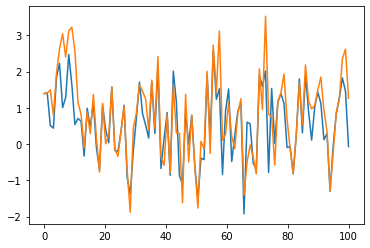

In [23]:
# Definindo v(n)
np.random.seed(8008135)
mean = 0.5
std = 1
n = 100
v = np.random.normal(mean, std, size=n)

# Definindo x(n)
x = []
for i in range(n):
    a = 0 if i-1 < 0 else v[i-1]
    b = 0 if i-2 < 0 else v[i-2]
    x.append(v[i] + 0.5*a*b)

plt.plot(np.linspace(0,n,n), v)
plt.plot(np.linspace(0,n,n), x)
plt.show()

